<a href="https://colab.research.google.com/github/G-Gaddu/Quant-Material/blob/main/Heston_model_to_price_Apple_options.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import yfinance as yf
import pandas as pd
import io
import numpy as np
import scipy.optimize as opt
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [4]:
import warnings
warnings.filterwarnings('ignore')


Data preparation

In [5]:
 # Define the ticker symbol for Apple
ticker = "AAPL"

# Get the options data for Apple
apple = yf.Ticker(ticker)
options = apple.options

calls_df_list = []
puts_df_list = []

# Iterate through each expiration date and get the option chain
for expiration_date in options:
  option_chain = apple.option_chain(expiration_date)
  calls = option_chain.calls
  puts = option_chain.puts

  expiration_datetime = datetime.strptime(expiration_date, '%Y-%m-%d')
  today = datetime.today()
  time_to_maturity = (expiration_datetime - today).days / 365

  calls['Expiration Date'] = expiration_date
  calls['Time to Maturity'] = time_to_maturity
  puts['Expiration Date'] = expiration_date
  puts['Time to Maturity'] = time_to_maturity

  calls_df_list.append(calls)
  puts_df_list.append(puts)

calls_df = pd.concat(calls_df_list, ignore_index=True)
puts_df = pd.concat(puts_df_list, ignore_index=True)

# Keep only the desired columns
calls_df = calls_df[['lastPrice', 'strike', 'impliedVolatility', 'Expiration Date', 'Time to Maturity']]
puts_df = puts_df[['lastPrice', 'strike', 'impliedVolatility', 'Expiration Date', 'Time to Maturity']]

print("Calls DataFrame:")
print(calls_df)
print("\nPuts DataFrame:")
print(puts_df)


Calls DataFrame:
      lastPrice  strike  impliedVolatility Expiration Date  Time to Maturity
0        211.64     5.0          14.187501      2024-09-20          0.005479
1        215.85    10.0          15.859375      2024-09-20          0.005479
2        207.25    15.0           9.687504      2024-09-20          0.005479
3        205.90    20.0          11.859378      2024-09-20          0.005479
4        201.40    25.0          10.910159      2024-09-20          0.005479
...         ...     ...                ...             ...               ...
1008      10.25   310.0           0.267646      2026-12-18          2.249315
1009       8.46   320.0           0.264168      2026-12-18          2.249315
1010       7.25   330.0           0.261833      2026-12-18          2.249315
1011       6.22   340.0           0.267799      2026-12-18          2.249315
1012       5.20   350.0           0.259407      2026-12-18          2.249315

[1013 rows x 5 columns]

Puts DataFrame:
     lastPrice  s

In [6]:
# For the call and put dataframes and drop the expiration dates

calls_df = calls_df.drop('Expiration Date', axis=1)
puts_df = puts_df.drop('Expiration Date', axis=1)


Define the functions that we will neeed for calibration and pricing

In [7]:
def heston_characteristic(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):
  # Define the constants
  a = kappa * theta
  b = kappa + lambd
  rspi = rho*sigma*phi*1j
  # Define the d parameters
  d = np.sqrt((rho*sigma*phi*1j-b)**2 + (phi*1j+phi**2)*sigma**2)
  # Define the g parameter
  g = (b-rspi+d)/(b-rspi-d)
  # Determine the function by it's components
  exp1 = np.exp(r*phi*1j*tau)
  term2 = S0**(phi*1j)*((1-g*np.exp(d*tau))/(1-g))**(-2*a/sigma**2)
  exp2 = np.exp(a*tau*(b-rspi+d)/sigma**2+v0*(b-rspi+d)*((1-np.exp(d*tau))/(1-g*np.exp(d*tau)))/sigma**2)

  return exp1*term2*exp2


In [8]:
def integrand(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):
  args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)
  numerator = np.exp(r*tau)*heston_characteristic(phi-1j,*args) - K*heston_characteristic(phi,*args)
  denominator = 1j*phi*K**(1j*phi)
  return numerator/denominator


In [22]:
def heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r, option_type):
  args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)
  P, umax, N = 0, 100, 10000
  dphi = umax/N

  for i in range(1,N):
    phi = dphi*(2*i+1)/2
    numerator = np.exp(r*tau)*heston_characteristic(phi-1j,*args) - K*heston_characteristic(phi,*args)
    denominator = 1j*phi*K**(1j*phi)
    P += dphi * numerator/denominator
  if option_type == "Call":
    return np.maximum(np.real((S0-K*np.exp(-r*tau))/2 + P/np.pi), 0.01)  # Ensure positive value
  elif option_type == "Put":
    return np.maximum(np.real((K*np.exp(-r*tau)-S0)/2 + P/np.pi), 0.01)  # Ensure positive value

In [24]:
def heston_price(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r, option_type):
  args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)
  real_integral, err = np.real(quad(integrand, 0, 100, args=args))
  if option_type == "Call":
    return np.maximum((S0 - K*np.exp(-r*tau))/2 + real_integral/np.pi, 0.01)  # Ensure positive value
  elif option_type == "Put":
    return np.maximum((K*np.exp(-r*tau) - S0)/2 + real_integral/np.pi, 0.01)  # Ensure positive value


Run the Calibration

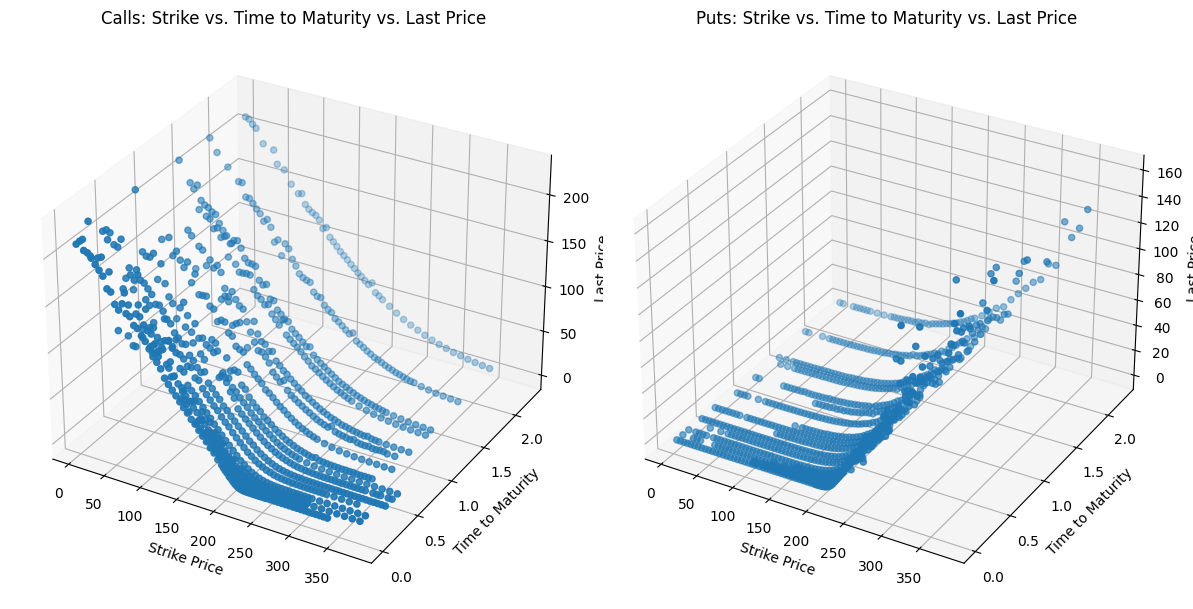

In [25]:
# Plot the strikes, time to maturity and lastPrice for the calls and puts separately on a 3d plot

fig = plt.figure(figsize=(12, 6))

# Plot for Calls
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(calls_df['strike'], calls_df['Time to Maturity'], calls_df['lastPrice'])
ax1.set_xlabel('Strike Price')
ax1.set_ylabel('Time to Maturity')
ax1.set_zlabel('Last Price')
ax1.set_title('Calls: Strike vs. Time to Maturity vs. Last Price')

# Plot for Puts
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(puts_df['strike'], puts_df['Time to Maturity'], puts_df['lastPrice'])
ax2.set_xlabel('Strike Price')
ax2.set_ylabel('Time to Maturity')
ax2.set_zlabel('Last Price')
ax2.set_title('Puts: Strike vs. Time to Maturity vs. Last Price')

plt.tight_layout()
plt.show()


In [48]:
# Take a subset for the calls and puts dataframes which the time to maturity is less than or equal to 6 months

calls_df_subset = calls_df[calls_df['Time to Maturity'] <= 0.5]
puts_df_subset = puts_df[puts_df['Time to Maturity'] <= 0.5]



In [49]:
# Define the parameters to be used in calibration and  the minimisation function
params = {"v0": {"x0": 0.1, "lbub": [1e-3,0.1]},
          "kappa": {"x0": 3, "lbub": [1e-3,5]},
          "theta": {"x0": 0.05, "lbub": [1e-3,0.1]},
          "sigma": {"x0": 0.3, "lbub":[1e-2,1]},
          "rho": {"x0":-0.8, "lbub":[-1,0]},
          "lambd":{"x0":0.03, "lbub":[-1,1]},
          }

x0 = [param["x0"] for key, param in params.items()]
bnds = [param["lbub"] for key, param in params.items()]

def SqErr(x):
  v0, kappa, theta, sigma, rho, lambd = [param for param in x]
  err = np.sum((P-heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r, option_type="Put"))**2/len(P))
  pen = 0
  return err + pen

In [50]:
# Run the calibration for the calls only, let S0 be 215.46 (price of underlying asset) and r be  0.03968 (the yield on a 1 year US treasury)

# Prepare the data for calibration (using calls_df)
S0 = 215.46
r = 0.03968

# Prepare the input data for the calibration function
K = calls_df_subset['strike'].values
tau = calls_df_subset['Time to Maturity'].values
P = calls_df_subset['lastPrice'].values

# Run the calibration for the calls only
res = minimize(SqErr, x0, tol=1e-3, method='SLSQP', bounds=bnds, options={'maxiter':1e4})
print(res)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 7500.9611058978035
       x: [ 1.000e-01  1.000e-03  1.000e-01  1.000e+00 -1.000e+00
           -1.000e+00]
     nit: 6
     jac: [-8.785e+01  4.970e+00  1.532e-02 -3.999e+01  9.085e+01
            3.396e+00]
    nfev: 44
    njev: 6


In [51]:
v0, kappa, theta, sigma, rho, lambd = [param for param in res.x]
v0, kappa, theta, sigma, rho, lambd

(0.1, 0.0009999999999998899, 0.1, 1.0, -1.0, -0.9999998047244478)

In [52]:
# Prepare the input data for the calibration function
K_puts = puts_df_subset['strike'].values
tau_puts = puts_df_subset['Time to Maturity'].values
P_puts = puts_df_subset['lastPrice'].values

# Convert K_puts and tau_puts to numpy arrays
K_puts = np.array(K_puts)
tau_puts = np.array(tau_puts)

# Calculate the put prices using the calibrated parameters and the Heston model
put_prices = [heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r, option_type="Put") for K, tau in zip(K_puts, tau_puts)]

# Print the calculated put prices
print("Calculated Put Prices:")
print(put_prices)


Calculated Put Prices:
[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.014516638265668291, 0.01, 0.042293566752611866, 0.01, 0.05925827434558606, 0.01, 0.03643634930448414, 0.07037033141482141, 0.037752650883686734, 0.01, 0.04018534517422623, 0.1961195420945332, 0.46954248226515194, 0.9324031525240488, 1.7494337416522714, 3.0750145601523484, 4.923243030349119, 7.146146568786988, 9.539799712694906, 11.972440006138026, 14.422965680121273, 16.91992987519982, 19.46316084231256, 22.006482696765595, 24.503303768697123, 26.954514074477878, 29.406360713697534, 31.903521700827074, 34.44632658702527, 36.99228225590424, 39.4969460756073, 44.39913393132453, 49.40371890240536, 54.48231165057584, 59.41216695201855, 64.35100764857893, 74.43873079153005, 84.3337579842397, 94.38021109763206, 99.28053194507467, 109.37255661943844, 0.01, 0.01, 0.01, 0.01, 0.02

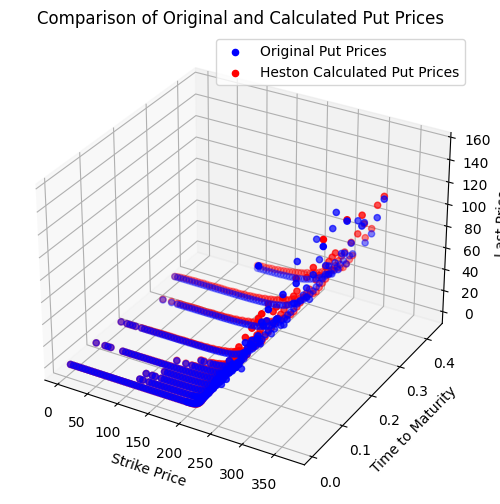

In [53]:
# Plot the put prices and calculated prices on the same plot for the strikes and time to maturity
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the original put prices
ax.scatter(puts_df_subset['strike'], puts_df_subset['Time to Maturity'], puts_df_subset['lastPrice'], label='Original Put Prices', color='blue')

# Plot the calculated put prices
ax.scatter(puts_df_subset['strike'], puts_df_subset['Time to Maturity'], put_prices, label='Heston Calculated Put Prices', color='red')

ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Last Price')
ax.set_title('Comparison of Original and Calculated Put Prices')
ax.legend()

plt.show()


In [54]:
# Create a DataFrame with put prices and calculated prices
put_price_df = pd.DataFrame({'Strike': K_puts, 'Time to Maturity': tau_puts, 'Original Put Price': P_puts, 'Heston Calculated Put Price': put_prices})

# Display the DataFrame
print(put_price_df)


     Strike  Time to Maturity  Original Put Price  Heston Calculated Put Price
0       5.0          0.005479                0.01                     0.010000
1      10.0          0.005479                0.01                     0.010000
2      15.0          0.005479                0.01                     0.010000
3      20.0          0.005479                0.01                     0.010000
4      25.0          0.005479                0.01                     0.010000
..      ...               ...                 ...                          ...
474   250.0          0.427397               28.75                    28.819337
475   255.0          0.427397               37.25                    33.702176
476   260.0          0.427397               39.95                    38.302942
477   280.0          0.427397               53.47                    58.271216
478   290.0          0.427397               63.45                    68.268181

[479 rows x 4 columns]


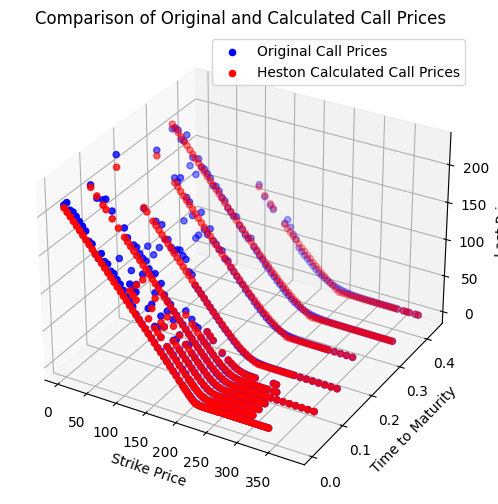

In [55]:
# Calculate the call prices using the calibrated parameters and the Heston model
call_prices = [heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r, option_type="Call") for K, tau in zip(calls_df_subset['strike'], calls_df_subset['Time to Maturity'])]

# Plot the call prices and calculated prices on the same plot for the strikes and time to maturity
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the original call prices
ax.scatter(calls_df_subset['strike'], calls_df_subset['Time to Maturity'], calls_df_subset['lastPrice'], label='Original Call Prices', color='blue')

# Plot the calculated call prices
ax.scatter(calls_df_subset['strike'], calls_df_subset['Time to Maturity'], call_prices, label='Heston Calculated Call Prices', color='red')

ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Last Price')
ax.set_title('Comparison of Original and Calculated Call Prices')
ax.legend()

plt.show()


In [56]:
# Create a DataFrame with original and calculated call prices
comparison_df = pd.DataFrame({
    'Strike': calls_df_subset['strike'],
    'Time to Maturity': calls_df_subset['Time to Maturity'],
    'Original Call Price': calls_df_subset['lastPrice'],
    'Heston Calculated Call Price': call_prices
})

# Display the DataFrame
print(comparison_df)


     Strike  Time to Maturity  Original Call Price  \
0       5.0          0.005479               211.64   
1      10.0          0.005479               215.85   
2      15.0          0.005479               207.25   
3      20.0          0.005479               205.90   
4      25.0          0.005479               201.40   
..      ...               ...                  ...   
533   355.0          0.427397                 0.09   
534   360.0          0.427397                 0.05   
535   365.0          0.427397                 0.05   
536   375.0          0.427397                 0.04   
537   380.0          0.427397                 0.06   

     Heston Calculated Call Price  
0                      207.971059  
1                      203.482320  
2                      198.825575  
3                      194.009727  
4                      189.220262  
..                            ...  
533                      0.010000  
534                      0.010000  
535                      0.

In [61]:
# Get the performance metrics
# Calculate performance metrics for calls
call_mse = mean_squared_error(comparison_df['Original Call Price'], comparison_df['Heston Calculated Call Price'])
call_rmse = np.sqrt(call_mse)
call_mae = mean_absolute_error(comparison_df['Original Call Price'], comparison_df['Heston Calculated Call Price'])
call_mpe = np.mean(np.abs((comparison_df['Original Call Price'] - comparison_df['Heston Calculated Call Price']) / comparison_df['Original Call Price'])) * 100
call_r2 = r2_score(comparison_df['Original Call Price'], comparison_df['Heston Calculated Call Price'])


print("Call Option Performance Metrics:")
print(f"Mean Squared Error (MSE): {call_mse}")
print(f"Root Mean Squared Error (RMSE): {call_rmse}")
print(f"Mean Absolute Error (MAE): {call_mae}")
print(f"R-squared (R2): {call_r2}")

# Calculate performance metrics for puts
put_mse = mean_squared_error(put_price_df['Original Put Price'], put_price_df['Heston Calculated Put Price'])
put_rmse = np.sqrt(put_mse)
put_mae = mean_absolute_error(put_price_df['Original Put Price'], put_price_df['Heston Calculated Put Price'])
put_mpe = np.mean(np.abs((put_price_df['Original Put Price'] - put_price_df['Heston Calculated Put Price']) / put_price_df['Original Put Price'])) * 100
put_r2 = r2_score(put_price_df['Original Put Price'], put_price_df['Heston Calculated Put Price'])

print("\nPut Option Performance Metrics:")
print(f"Mean Squared Error (MSE): {put_mse}")
print(f"Root Mean Squared Error (RMSE): {put_rmse}")
print(f"Mean Absolute Error (MAE): {put_mae}")
print(f"R-squared (R2): {put_r2}")


Call Option Performance Metrics:
Mean Squared Error (MSE): 35.38634377219486
Root Mean Squared Error (RMSE): 5.948642178866944
Mean Absolute Error (MAE): 2.6280458145919243
R-squared (R2): 0.9895393479795364

Put Option Performance Metrics:
Mean Squared Error (MSE): 24.00214117824457
Root Mean Squared Error (RMSE): 4.899198013781906
Mean Absolute Error (MAE): 2.375432270406856
R-squared (R2): 0.9646964819640963
